## EDA of scrapped Subreddit posts & comments

### Wordcloud

In [ ]:
import pandas as pd
import os
import re
import string
import numpy as np
import dotenv
from dotenv import load_dotenv

load_dotenv()

from datasets import load_dataset
from huggingface_hub import login, notebook_login, HfApi

login(token= os.getenv('HUGGINGFACE_TOKEN'))
api = HfApi()

dataset = load_dataset("choo-c102/rpancreatic_cancer_symptoms", split="train")
pc_df_clean = dataset.to_pandas()

# Clean messy raw posts
def clean_text(text):
    # Convert to string first to avoid errors with regex
    if pd.isna(text) or str(text).strip() == "":
        return np.nan  # Treat empty or missing values as NaN
    
    # Convert to lower case
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove unwanted special characters, keep common punctuation
    text = re.sub(r"[^a-zA-Z0-9\s.,!?;:'\"()\[\]\-]", '', text)

    # Replace line breaks and extra spaces with a single space
    text = text.replace('\n', ' ').strip()
    text = re.sub(r'\s+', ' ', text)
    
    return text

pc_df_clean['clean_text'] = pc_df_clean['Text'].apply(clean_text)
pc_df_clean['clean_text']

# Drop posts with no texts
pc_df_clean.dropna(subset=['clean_text'], inplace=True)
pc_df_clean.head()


,Type,Post_id,Title,Author,Timestamp,Text,Score,Flair,Total_comments,Post_URL,clean_text
0,Post,1bom69c,How long did you have symptoms before you got ...,Regular-Exchange-557,1.711494e+09,I know this has been asked but I’m curious how...,29,"worried, no diagnosis",308,https://www.reddit.com/r/pancreaticcancer/comm...,i know this has been asked but im curious how ...
1,Comment,1bom69c,How long did you have symptoms before you got ...,gage1a,1.711569e+12,They say hindsight is 20/20 and in my wife's c...,16,NaN,0,NaN,they say hindsight is 2020 and in my wife's ca...
2,Comment,1bom69c,How long did you have symptoms before you got ...,Lopsided-Dot9554,1.711496e+12,My dad had started complaining of a stomach ac...,15,NaN,0,NaN,my dad had started complaining of a stomach ac...
3,Comment,1bom69c,How long did you have symptoms before you got ...,Dazzling-March7258,1.711496e+12,Had back pain for a month or more before diagn...,12,NaN,0,NaN,had back pain for a month or more before diagn...
4,Comment,1bom69c,How long did you have symptoms before you got ...,Emergency_Wrangler68,1.711508e+12,I was complaining to my PCP for EIGHTEEN MONTH...,10,NaN,0,NaN,i was complaining to my pcp for eighteen month...


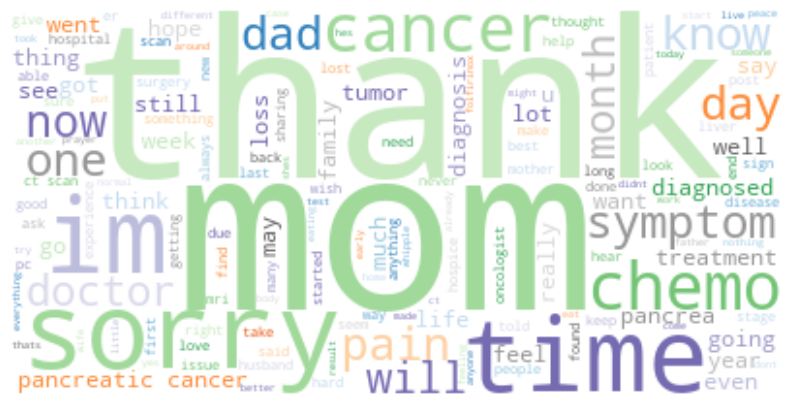

In [14]:
''' Wordcloud of all words '''
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

text = " ".join(pc_df_clean['clean_text'].dropna())

# remove words that are likely to dominate the contents 

text_cloud = WordCloud(
    stopwords = STOPWORDS,
    colormap = 'tab20c',
    background_color = 'white',
    collocations = True).generate(text)

fig = plt.figure(figsize = (10,7))
plt.imshow(text_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

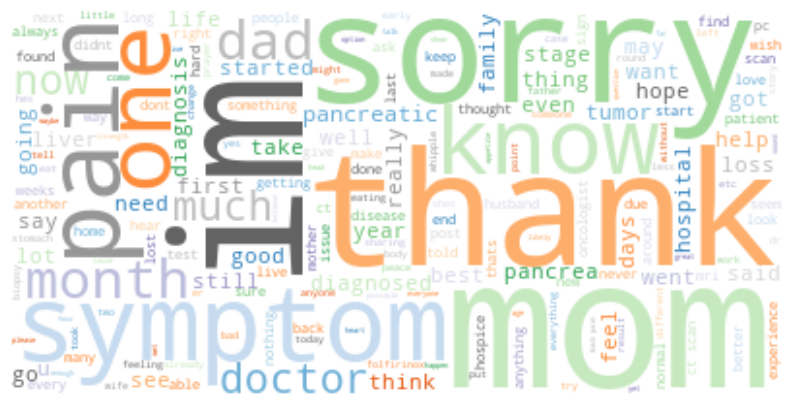

In [ ]:
#without custom stopwords

text = " ".join(pc_df_clean['clean_text'].dropna())

# remove words that are likely to dominate the contents 
custom_stopwords = {'cancer',
                    'treatment',
                    'radiation',
                    'chemo',
                    's',
                    'time',
                    'week',
                    'day',
                    'surgery',
                    'will',
                    'm'}

text_cloud = WordCloud(
    stopwords = STOPWORDS.union(custom_stopwords),
    colormap = 'tab20c',
    background_color = 'white',
    collocations = True).generate(text)

fig = plt.figure(figsize = (10,7))
plt.imshow(text_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()


### Topic Modelling - LDA

In [ ]:
#Import the vectorizer
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#downloading necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(nltk_pos):
    if nltk_pos.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif nltk_pos.startswith('V'):
        return wordnet.VERB  # Verb
    elif nltk_pos.startswith('N'):
        return wordnet.NOUN  # Noun
    elif nltk_pos.startswith('R'):
        return wordnet.ADV   # Adverb
    else:
        return None 

lemmatizer = WordNetLemmatizer()

#adding generic words and non-relevant words to the stopwords list 
#based on wordcloud and results from manually scanning the contents

new_stopwords = {'back','go','like','get','take','feel','see','also','will','would','lot','stuff','maybe','even',
                'actually','probably','may','sure','post','around','one','still','someone','thing','analyst','might','want',
                'well','two','pretty','anything','something','already','never','able','ago','bit','cause','cuz','basically',
                'yes','no','never','almost','anyone'} 
custom_stopwords.update(new_stopwords)
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Filter out non-alphabetic tokens
    pos_tags = nltk.pos_tag(tokens)  # Part-of-speech tagging
    lemmatized = []
    for word, pos_tag in pos_tags:
        wordnet_pos = get_wordnet_pos(pos_tag)
        if wordnet_pos is not None:
            lemma = lemmatizer.lemmatize(word, wordnet_pos)
            lemmatized.append(lemma)

    # Replace 'analysis' with 'analytics' after lemmatization
    lemmatized = ['analytics' if word == 'analysis' else word for word in lemmatized]

    lemmatized = [word for word in lemmatized if word not in stop_words]  # Remove stopwords
    return ' '.join(lemmatized)

tokenized = pc_df_clean['clean_text'].apply(preprocess)

In [ ]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

#Test with both bigrams and trigrams as a lot of phrases were used in the comments
vect = TfidfVectorizer(max_features = 100, ngram_range = (1,2), min_df = 5, max_df = 0.5).fit(tokenized)

X_text = vect.fit_transform(tokenized)

#changing sparse matrix into dataframe to be more readable
X_df = pd.DataFrame(X_text.toarray(), columns = vect.get_feature_names_out())

In [ ]:
X_df.head()

,ask,bad,best,big,biopsy,care,cisplatin,come,different,doctor,...,tube,tumor,use,wait,water,way,weight,wish,work,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


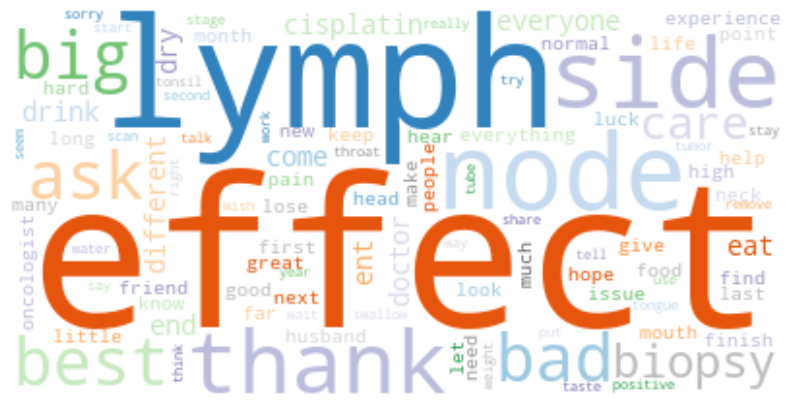

In [ ]:
string = ' '.join(X_df.columns)

text_cloud = WordCloud(
    stopwords = STOPWORDS.union(custom_stopwords),
    colormap = 'tab20c',
    background_color = 'white',
    collocations = True).generate(string)

fig = plt.figure(figsize = (10,7))
plt.imshow(text_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=5, 
                                      random_state=42,
                                      learning_method = 'online')

#to fit the LDA model, we have to use the sparse matrix
lda_model.fit(X_text)

lda_output = lda_model.fit_transform(X_text)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=42)


In [ ]:
#Examining model performance before tuning

print("Log Likelihood: ", lda_model.score(X_text))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(X_text))

Log Likelihood:  -31573.744127172773
Perplexity:  188.11387139135454


In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

tf_feature_names = vect.get_feature_names_out()
display_topics(lda_model, tf_feature_names, no_top_words=10)

Topic 0:
thanks hope sorry effect side best care luck side effect life
Topic 1:
neck scan ask doctor tongue say need first node husband
Topic 2:
use eat help mouth make tube taste food find water
Topic 3:
thank share much stay keep hear great positive try way
Topic 4:
know work year wish say good think people look give


In [ ]:
''' Finetune hyperparameters for LDA '''

from sklearn.model_selection import RandomizedSearchCV

search_params = {
  'n_components': [5, 8, 10, 15, 20], # Number of topics
  'learning_decay': [.5, .7, .9],  # Learning decay
  'learning_offset': [10, 50, 100],  # Learning offset
  'max_iter': [10, 50, 100]  # Max learning iterations
}

# init lda model
lda = LatentDirichletAllocation()

# init random search
rs_model = RandomizedSearchCV(lda, param_distributions=search_params, n_iter=10)
rs_model.fit(X_text)

# best model
best_lda_model = rs_model.best_estimator_

# Get best model outputs
print("Best Model's Params: ", rs_model.best_params_)
print("Best Log Likelihood Score: ", rs_model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(X_text))

Best Model's Params:  {'n_components': 5, 'max_iter': 100, 'learning_offset': 100, 'learning_decay': 0.5}
Best Log Likelihood Score:  -6851.033037462794
Model Perplexity:  189.3257001329213


In [ ]:
''' Input best params, fit, and examine performance '''
tuned_lda_model = LatentDirichletAllocation(n_components=5, 
                                            random_state= 42,
                                            learning_offset = 100,
                                            learning_decay = 0.5,
                                            learning_method = 'online',
                                            max_iter = 100)

tuned_lda_model.fit(X_text)

# Results
print("Log Likelihood: ", tuned_lda_model.score(X_text))
print("Perplexity: ", tuned_lda_model.perplexity(X_text))

Log Likelihood:  -31395.623801173253
Perplexity:  182.6374727079634


In [ ]:
# Topics after tuning LDA
tf_feature_names = vect.get_feature_names_out()
display_topics(tuned_lda_model, tf_feature_names, no_top_words=13)

Topic 0:
thanks hope sorry best great effect side luck care side effect friend life many
Topic 1:
neck ask scan doctor say tongue first pain month node husband remove lymph
Topic 2:
use eat taste month mouth tube food start swallow water find good make
Topic 3:
thank hear keep share much stay make positive really good experience new put
Topic 4:
know people think work wish help good say year look tell give need


In [ ]:
import pyLDAvis
import pyLDAvis.lda_model

# visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.lda_model.prepare(tuned_lda_model, X_text, vect, mds ='tsne')

LDAvis_prepared

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      21.055689  -6.516290       1        1  31.279359
1      46.132763  42.581654       2        1  26.539770
4       5.094953  46.648643       3        1  17.759988
0     -16.918211   9.885548       4        1  13.058851
3      61.425598   2.534391       5        1  11.362032, topic_info=      Term        Freq       Total Category  logprob  loglift
83   thank  156.000000  156.000000  Default  30.0000  30.0000
84  thanks   99.000000   99.000000  Default  29.0000  29.0000
30    hear   83.000000   83.000000  Default  28.0000  28.0000
36    keep  104.000000  104.000000  Default  27.0000  27.0000
52    much  121.000000  121.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
54    need    0.274162   80.196860   Topic5  -7.8235  -3.5036
68     say    0.273699  108.744406   Topic5  -7.8252  -3.8098
84  thanks    0.273347   99.347860   Topic5  -7.8264  -3.7207
95     way    0.273082   57.812459   Topic5  -7.8274  -3.1803
1      bad    0.272967   74.757357   Topic5  -7.8278  -3.4378

[225 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         2  0.986163   ask
1         1  0.441428   bad
1         2  0.173896   bad
1         3  0.387922   bad
2         3  0.340279  best
...     ...       ...   ...
98        2  0.085809  work
98        3  0.568482  work
99        1  0.277764  year
99        2  0.296920  year
99        3  0.411857  year

[216 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

Topic 1: Nutrition and Eating Challenges
With words such as "eat," "taste," "mouth," "tube," "food," "swallow," and "water," this topic appears related to the challenges patients face with eating, tasting, or swallowing, which are often impacted by head and neck cancer treatments. There may also be discussions on managing nutrition through feeding tubes.

Topic 2: Medical Appointments and Procedures
Keywords like "neck," "scan," "doctor," "tongue," "node," "remove," and "lymph" indicate discussions about diagnostic and treatment procedures, possibly including doctor visits, scans, surgical interventions, or lymph node removal common in head and neck cancer.

Topic 3: Seeking Advice and Sharing Knowledge
Words like "know," "people," "think," "help," "say," "tell," and "need" indicate discussions where people are seeking advice, sharing knowledge, and expressing needs or questions. This might involve conversations on understanding treatments, navigating care, or discussing life adjustments post-diagnosis

Topic 4 & 5: Positive Experiences and Community Support
Keywords like "thank," "hear," "keep," "share," "positive," and "experience" suggest positive exchanges within the community, where patients and caregivers share experiences, encouraging words, and support.